이 코드는 아래 repository의 코드를 활용한 것입니다.
- https://github.com/arumugamramaswamy/Jack-s-Car-Rental/blob/master/Jack's%20Car%20Rental.ipynb

In [94]:
import numpy as np
import copy
import math
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

def timit(func):
    def wrapper(*args,**kwargs):
        t1 = time.perf_counter()
        func(*args,**kwargs)
        print("Time taken by {} to run".format(func.__name__),time.perf_counter()-t1)
    return wrapper

# Jack's Car Rental
Here are key specific points about the problem:

- 2 locations A, B
- Each location can only hold 20 cars.
- Every time a car is rented, we earn $10 (Reward)
- Every time we move a car overnight to another location, it costs us $2 (Negative Reward).
- The maximum number of cars we can move overnight is 5 (Action).
- The number of cars requested and returned at each location (n) on any given day are Poisson random variables.
- The expected number (lambda) of rental requests at the first and second location is 3 and 4 respectively.
- The expected number of rental returns at the first and second location is 3 and 2 respectively.
- Our discount rate for future returns, (γ), is 0.9.
- The time step are days (thus, one step in an iteration can be considered a full day), the state is the number of cars at each location at the end of the day, and the actions are the net number of cars moved between the two locations overnight.

In [12]:
class CarRental:
    '''
    Here we build the model for the enviroment Jack's Car Rental
    The problem is formulated as a continuing MDP with a discount rate = 0.9
    
    We first construct the possible transitions from the previous state.
    Each transition is to be broken into two pieces:
        - Transitions due to rental requests the previous day
        - Transitions due to rental returns the previous day
    
    While calculating the probabilities for the rental returns and requests, we 
    truncate the values of n sampled untill n = 11
    
    We create two transition look up dictionaries using the methods:
        - _get_posible_transitions_requests()
        - _get_posible_transitions_returns()
        
    The look up from the first dictionary is piped into the second dictionary
    to construct a complete transistion table.
    '''
    
    @staticmethod
    def _get_posible_transitions_requests():
        '''
        This method constructs the transition look up dictionary 
        for rental requests the previous day.
        
        The structure of the object returned is as follows:
        {
            state :{
                state_before_returns :{
                    "probability": transistion probability,
                    "reward": transition reward
                } 
            }
        }
        '''
        states = {x:{} for x in range(441)}

        requests_a_prob = CarRental._get_poison(
            np.array([x for x in range(12)]),
            3
        )
        requests_a = np.array(list(zip([x for x in range(12)],requests_a_prob)))
        
        requests_b_prob = CarRental._get_poison(
            np.array([x for x in range(12)]),
            4
        )
        requests_b = np.array(list(zip([x for x in range(12)],requests_b_prob)))
  
        for state in states:
            num_cars_a, num_cars_b = np.unravel_index(state,(21,21))
            
            reward_req_a = np.minimum(requests_a[:,0],num_cars_a)*10
            reward_req_b = np.minimum(requests_b[:,0],num_cars_b)*10
            
            for x in range(1,12):
                for y in range(1,12):
                    
                    new_state_a = max(0, num_cars_a-x)
                    new_state_b = max(0, num_cars_b-y)
                    new_state = np.ravel_multi_index((new_state_a,new_state_b),(21,21))
                    if new_state not in states[state]:
                        states[state][new_state] = {
                            "probability": requests_a_prob[x]*requests_b_prob[y],
                            "reward": reward_req_a[x]+reward_req_b[y]
                        }
                    else:
                        states[state][new_state]["probability"] += requests_a_prob[x]*requests_b_prob[y]
            

        return states
    
    @staticmethod
    def _get_posible_transitions_returns():
        '''
        This method constructs the transition look up dictionary 
        for rental returns the previous day.
        
        The structure of the object returned is as follows:
        {
            state_before_returns :{
                state_after_returns :{
                    "probability": transistion probability
                } 
            }
        }
        '''
        states = {x:{} for x in range(441)}
        
        returns_a_prob = CarRental._get_poison(
            np.array([x for x in range(12)]),
            3
        )
        returns_a = np.array(list(zip([x for x in range(12)],returns_a_prob)))
                
        returns_b_prob = CarRental._get_poison(
            np.array([x for x in range(12)]),
            2
        )
        returns_b = np.array(list(zip([x for x in range(12)],returns_b_prob)))
  
        for state in states:
            num_cars_a, num_cars_b = np.unravel_index(state,(21,21))
            
            for x in range(1,12):
                for y in range(1,12):
                    
                    new_state_a = min(20, num_cars_a+x)
                    new_state_b = min(20, num_cars_b+y)
                    new_state = np.ravel_multi_index((new_state_a,new_state_b),(21,21))
                    if new_state not in states[state]:
                        states[state][new_state] = {
                            "probability": returns_a_prob[x]*returns_b_prob[y],
                        }
                    else:
                        states[state][new_state]["probability"] += returns_a_prob[x]*returns_b_prob[y]
            

        return states
    
    @staticmethod
    def _get_possible_actions(state):
        '''
        Given a state, this function returns a dictionary of possible actions and the results of those actions.
        
        The structure of the object returned is as follows:

        {
            state_before_action :{
                "new_state": state_after_action,
                "reward": reward due to action
            }
        }
        '''
        actions = {}
        (num_cars_a, num_cars_b) = np.unravel_index(state,(21,21))
        move_a_to_b = min(5,num_cars_a)
        move_b_to_a = min(5,num_cars_b)
        for x in range(-move_b_to_a, move_a_to_b+1):
            new_state_a = min(20,num_cars_a-x)
            new_state_b = min(20,num_cars_b+x)
            actions[x] = {
                "new_state": np.ravel_multi_index((new_state_a,new_state_b),(21,21)),
                "reward": abs(x)*-2
            }
        return actions
    
    @staticmethod
    def _get_poison(x,n):
        return np.power(x,n)*np.exp(-x)/math.factorial(n)
    
    @timit
    def __init__(self):
        self.actions = [x-5 for x in range(11)]
        states_requests = self._get_posible_transitions_requests()
        states_returns = self._get_posible_transitions_returns()
        self.states = {}

        for state_before_request, transitions in states_requests.items():
            
            self.states[state_before_request] = {}
            
            for state_after_request, transition_details in transitions.items():
                

                for state_after_return, return_trasition_probability_dict in states_returns[state_after_request].items():
    
                    if state_after_return not in self.states[state_before_request]:
                        self.states[state_before_request][state_after_return] = {
                            "expected_reward":transition_details["reward"]* \
                            transition_details["probability"]*return_trasition_probability_dict["probability"],
                            "probability":transition_details["probability"]*return_trasition_probability_dict["probability"]
                        }

                    else:
                        self.states[state_before_request][state_after_return]["expected_reward"] += \
                            (transition_details["reward"]* transition_details["probability"]* \
                            return_trasition_probability_dict["probability"])
                        self.states[state_before_request][state_after_return]["probability"] += \
                            (transition_details["probability"]* return_trasition_probability_dict["probability"])

In [13]:
# initialisation
policy = {x:{y:(1 if y == 0 else 0) for y in CarRental._get_possible_actions(x)} for x in range(441)}
gamma = 0.9
value = [0]*441
a = CarRental()

Time taken by __init__ to run 1.8164378899964504


In [14]:
# policy evaluation
delta = 0
theta = 1
x = 0
while True:
    x += 1
    value_old = copy.deepcopy(value)

    for state_before_action in range(441):

        possible_actions_dict = CarRental._get_possible_actions(state_before_action)

        accumulator = 0

        for action, action_results_dict in possible_actions_dict.items():

            state_after_action = action_results_dict['new_state']
            reward_action = action_results_dict['reward']

            
            for state_after_transition, reward_transition_dict in a.states[state_after_action].items():
                expected_reward_transition = reward_transition_dict['expected_reward']
                probability_transition = reward_transition_dict['probability']
                expected_reward_action = reward_action*probability_transition
                total_expected_reward = (expected_reward_transition+expected_reward_action)*policy[state_before_action][action]
                accumulator += (total_expected_reward + gamma * \
                                probability_transition*policy[state_before_action][action]*value[state_after_transition])


        value[state_before_action] = accumulator
    
    
    delta = max(map(lambda x: abs(x[0]-x[1]),zip(value, value_old)))
    if delta <theta:
        break
print("Number of iterations in the function iterative_policy_evaluation_one_step_online:",x)

Number of iterations in the function iterative_policy_evaluation_one_step_online: 24


In [15]:
# policy improvement
for state_before_action in range(441):

    max_val = -math.inf
    max_action = None
    
    possible_actions_dict = CarRental._get_possible_actions(state_before_action)


    for action, action_results_dict in possible_actions_dict.items():

        state_after_action = action_results_dict['new_state']
        reward_action = action_results_dict['reward']
        
        accumulator = 0

        for state_after_transition, reward_transition_dict in a.states[state_after_action].items():
            expected_reward_transition = reward_transition_dict['expected_reward']
            probability_transition = reward_transition_dict['probability']
            expected_reward_action = reward_action*probability_transition
            total_expected_reward = (expected_reward_transition+expected_reward_action)
            accumulator += (total_expected_reward + gamma * \
                            probability_transition*value[state_after_transition])
        val = accumulator
        if val>max_val:
            max_val = val
            max_action = [action]

        elif val == max_val:
            max_action.append(action)
    for action in possible_actions_dict:
        if action in max_action:
            policy[state_before_action][action] = 1/len(max_action)
        else:
            policy[state_before_action][action] = 0

In [16]:
# plotting
twod_representation = np.zeros((21,21))

for state,actions in policy.items():
    num_cars_a, num_cars_b = np.unravel_index(state,(21,21))
    max_val = 0
    max_action = None
    for action, prob in actions.items():
        if prob>max_val:
            max_action = action
            max_val = prob
    twod_representation[num_cars_a][num_cars_b] = max_action

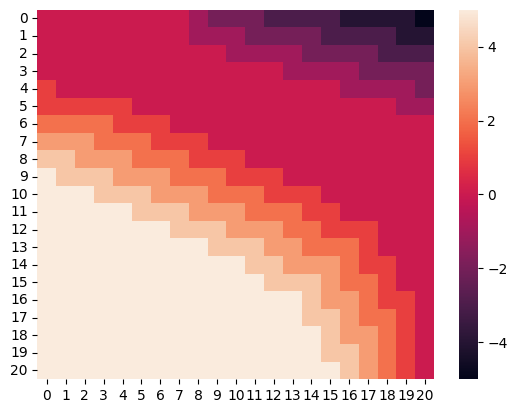

In [17]:
ax = sns.heatmap(twod_representation)

# Complete Policy Iteration

In [18]:
# initialisation
policy = {x:{y:(1 if y ==0 else 0) for y in CarRental._get_possible_actions(x)} for x in range(441)}
gamma = 0.9
value = [0]*441
a = CarRental()
plottables = []

while True:
    
    print("Starting policy evaluation ...")
    
    # plotting
    twod_representation = np.zeros((21,21))

    for state,actions in policy.items():
        num_cars_a, num_cars_b = np.unravel_index(state,(21,21))
        max_val = 0
        max_action = None
        for action, prob in actions.items():
            if prob>max_val:
                max_action = action
                max_val = prob
        twod_representation[num_cars_a][num_cars_b] = max_action
    
    plottables.append(copy.deepcopy(twod_representation))
    
    # policy evaluation
    delta = 0
    theta = 1
    x = 0
    while True:
        x += 1
        value_old = copy.deepcopy(value)

        for state_before_action in range(441):

            possible_actions_dict = CarRental._get_possible_actions(state_before_action)

            accumulator = 0

            for action, action_results_dict in possible_actions_dict.items():

                state_after_action = action_results_dict['new_state']
                reward_action = action_results_dict['reward']


                for state_after_transition, reward_transition_dict in a.states[state_after_action].items():
                    expected_reward_transition = reward_transition_dict['expected_reward']
                    probability_transition = reward_transition_dict['probability']
                    expected_reward_action = reward_action*probability_transition
                    total_expected_reward = (expected_reward_transition+expected_reward_action)* \
                                    policy[state_before_action][action]
                    accumulator += (total_expected_reward + gamma * \
                                    probability_transition*policy[state_before_action][action]*value[state_after_transition])

            value[state_before_action] = accumulator


        delta = max(map(lambda x: abs(x[0]-x[1]),zip(value, value_old)))
        if delta <theta:
            break
    print("Number of iterations in the function iterative_policy_evaluation_one_step_online:",x)

    # policy improvement
    policy_old = copy.deepcopy(policy)
    
    for state_before_action in range(441):

        max_val = -math.inf
        max_action = None

        possible_actions_dict = CarRental._get_possible_actions(state_before_action)


        for action, action_results_dict in possible_actions_dict.items():

            state_after_action = action_results_dict['new_state']
            reward_action = action_results_dict['reward']

            accumulator = 0

            for state_after_transition, reward_transition_dict in a.states[state_after_action].items():
                expected_reward_transition = reward_transition_dict['expected_reward']
                probability_transition = reward_transition_dict['probability']
                expected_reward_action = reward_action*probability_transition
                total_expected_reward = (expected_reward_transition+expected_reward_action)
                accumulator += (total_expected_reward + gamma * \
                                probability_transition*value[state_after_transition])
            val = accumulator
            if val>max_val:
                max_val = val
                max_action = [action]

            elif val == max_val:
                max_action.append(action)
        for action in possible_actions_dict:
            if action in max_action:
                policy[state_before_action][action] = 1/len(max_action)
            else:
                policy[state_before_action][action] = 0
                
    if policy == policy_old:
        break

Time taken by __init__ to run 1.825580283999443
Starting policy evaluation ...
Number of iterations in the function iterative_policy_evaluation_one_step_online: 24
Starting policy evaluation ...
Number of iterations in the function iterative_policy_evaluation_one_step_online: 8
Starting policy evaluation ...
Number of iterations in the function iterative_policy_evaluation_one_step_online: 5
Starting policy evaluation ...
Number of iterations in the function iterative_policy_evaluation_one_step_online: 1
Starting policy evaluation ...
Number of iterations in the function iterative_policy_evaluation_one_step_online: 1


# Policy Visualization

Policy after 0 steps of policy iteration


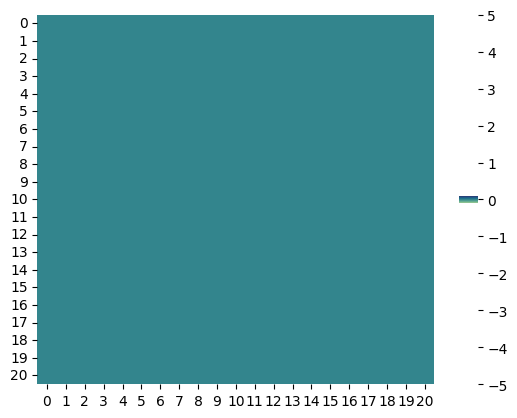

Policy after 1 steps of policy iteration


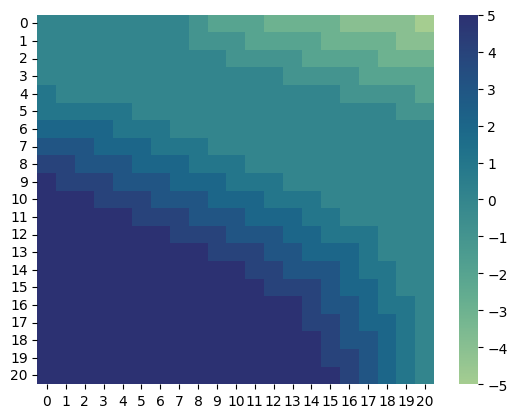

Policy after 2 steps of policy iteration


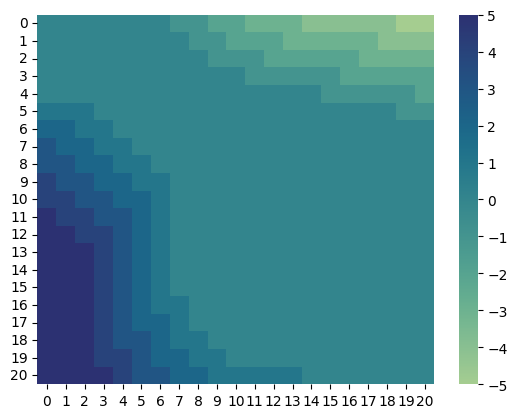

Policy after 3 steps of policy iteration


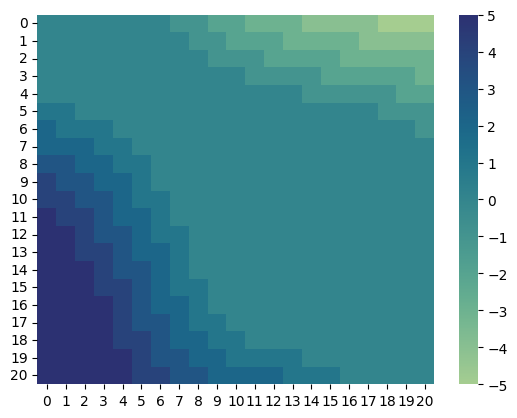

Policy after 4 steps of policy iteration


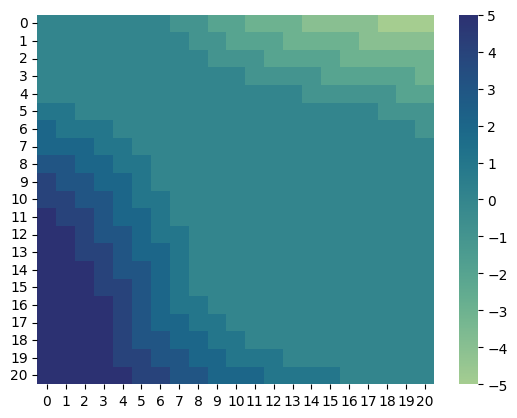

In [92]:
for ind, x in enumerate(plottables):
    ax = sns.heatmap(x, cmap='crest')
    colorbar = ax.collections[0].colorbar
    # The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
    r = colorbar.vmax - colorbar.vmin
    colorbar.set_ticks(range(-5, 6))
    print("Policy after {} steps of policy iteration".format(ind))
    plt.show()

# Value Funtion 3D Visualization

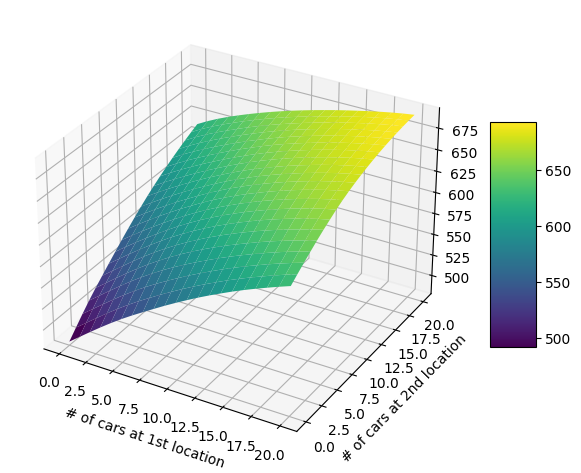

In [93]:
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

kx = np.linspace(0, 20, 21)
ky = np.linspace(0, 20, 21)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

KX, KY = np.meshgrid(kx, ky)

ax.set_xlabel('# of cars at 1st location')
ax.set_ylabel('# of cars at 2nd location')
surf = ax.plot_surface(KX, KY, np.array(value).reshape(21, 21), rstride=1, cstride=1, cmap=cm.viridis)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.tight_layout()
plt.show()